# Vibe Coding a modern diffusion pipeline (NVIDIA EDM, SR3, Toyota SR)

* Nvidia - Elucidating the Design Space of Diffusion-Based Generative Models - https://arxiv.org/abs/2206.00364
* Toyota - Efficient Burst Super-Resolution with One-step Diffusion - https://arxiv.org/abs/2507.13607
* Google SR3 - Image Super-Resolution via Iterative Refinement - https://arxiv.org/abs/2104.07636


## 1. Install and Import Required Libraries

We will use PyTorch, torchvision, numpy, matplotlib, and tqdm. If running locally, ensure these packages are installed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import base64
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms
from datetime import datetime
from io import BytesIO
from PIL import Image, ImageOps
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import io
import os

In [2]:
from elucidated_diffusion.elucidated_diffusion import edm_ancestral_sampling_for_diffusion
from elucidated_diffusion.elucidated_diffusion import edm_ancestral_sampling_for_sr
from elucidated_diffusion.elucidated_diffusion import P_mean, P_std, sigma_data, edm_loss_weight
from elucidated_diffusion.ema_helper import EMAHelper
#from elucidated_diffusion.models.chatgpt_diffusion_unet import UNet128
#from elucidated_diffusion.models.claude_diffusion_simple import create_vit_enhanced_unet
from elucidated_diffusion.models.claude_diffusion_ViTGradualTransition import create_gradual_transition_unet
from elucidated_diffusion.dataset_helpers import get_datasets
from elucidated_diffusion.checkpoint_helper import load_checkpoint, save_checkpoint



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HR = 256
LR = 64
max_training_time = 60*5
display_interval = 30

# https://www.kaggle.com/datasets/chetankv/dogs-cats-images
# https://www.kaggle.com/datasets/nerfviking/fantasyscifi-full-body-character-concepts
# https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset
experiments = {
    "fantasy": ("./data/fantasy", "checkpoints/UNet128_2025-09-14_17-47-44_fantasy.pth", "checkpoints/UNetSR3_2025-09-14_17-32-01_fantasy.pth"),
    "cats_and_dogs": ("./data/cats_and_dogs/dataset/training_set", "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth",None),
    "pokemon": ("./data/pokemon_archive","UNet128_2025-09-12_11-03-12_pokemon.pth",None),
    "dragon": ("utils/dataset_fetcher/datasets/", 'checkpoints/UNet128_2025-09-17_01-57-51_dragon.pth',None),
    "yugioh": ("data/yugioh/YuGiOhImages",None,None),
    "mnist": (None,None,None),
}

experiment_name = "dragon"
src_data, diffusion_weights,checkpoint_weights = experiments[experiment_name]

## 3. Define a Vision Mmodel for a Diffusion Model Architecture

* **Sinusoidal Timestep Embedding**
  * → Encodes diffusion step (time) as a multi-frequency vector. Lets the model “know” how much noise is present and what stage of denoising it’s in.
* **Optional Self-Attention at Lower Resolutions (e.g. 16×16)**
  * → Lets distant parts of the image “talk to each other,” useful for global structure (symmetry, object coherence). Limited to low-res maps to save compute.
* **SiLU/Swish activations**
  * → Smooth nonlinearities, empirically better than ReLU in diffusion U-Nets.

In [4]:
if show_model_info := False:
    #model = UNet128(use_attention=True).to(device)
    model = create_vit_enhanced_unet().to(device)
    print(model)

    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params}")

    from torchview import draw_graph
    #model = UNet128(use_attention=True).to(device)
    x,t = torch.rand(12, 3, 64, 64), torch.rand(12)
    #print(x,t)
    model_graph = draw_graph(model, input_data=(x,t), device='meta')
    model_graph.visual_graph

    type(model_graph.visual_graph)
    model_graph.visual_graph.render(filename='doc/diffusion_model_graph', format='svg', cleanup=True)
    model_graph.visual_graph.render(filename='doc/diffusion_model_graph', format='pdf', cleanup=True)
    svg_data = model_graph.visual_graph.pipe(format='svg')
    #ipd.display(ipd.SVG(svg_data))
    del(model)



## 4. Load and Preprocess Dataset

We will use any image directory for demonstration. The images will be normalized to [-1, 1] as required by most diffusion models.

In [5]:
lrds,_ = get_datasets(experiment_name)


## 4. Implement the Forward Diffusion Process

The forward process gradually adds Gaussian noise to the data over a fixed number of timesteps.

## 6. Elucidated Diffusion Model (EDM) Implementation

This section implements the EDM as described in the paper (2206.00364v2.pdf), including its unique noise schedule, loss weighting, and sampling procedure.

### 6a. EDM loss and schedule functions.

### 6b. EDM Sampling / Reconstruction

In [6]:
from elucidated_diffusion.image_helpers import pil_to_data_url, html_for_images

In [7]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_images(model_edm, num_steps=15, batch_size=20, img_shape = (3,64,64)):
    to_pil = transforms.ToPILImage()
    with torch.no_grad():
        samples = edm_ancestral_sampling_for_diffusion(model_edm, num_steps=num_steps, batch_size=batch_size, img_shape=(3, 64, 64)).cpu()
        samples = (samples + 1) / 2  # scale from [-1,1] to [0,1]
        samples = samples.clamp(0, 1)
        pil_images = [to_pil(img) for img in samples]
    return pil_images

def sample_html(model, batch_size=12, img_shape=(3,64,64), num_steps=36, title="EDM Samples",min_height=128):
    imgs = generate_images(model_edm=model, batch_size=batch_size, img_shape=img_shape, num_steps=16)
    h = html_for_images(imgs, title=title, min_height=min_height)
    return h


# 6c. EDM Training Loop 

In [8]:
# EDM training loop - CORRECTED with proper preconditioning coefficients
# Following NVIDIA's EDMPrecond implementation exactly

def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch.to(device)
        
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])
        F_x = model_edm(c_in * y_noisy, c_noise_input)
        
        # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
        D_x = c_skip * y_noisy + c_out * F_x
        
        # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
        weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
        
        # Loss: weighted MSE between preconditioning output and clean image
        loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        return loss.item()


In [9]:
device

device(type='cuda')

In [ ]:

def train_some(experiment_name):
   
    #model_edm = UNet128(use_attention=True).to(device)
    #model_edm = create_vit_enhanced_unet("lightweight").to(device)
    #model_edm = create_gradual_transition_unet("minimal").to(device)
    model_edm = create_gradual_transition_unet("efficient").to(device)
    optimizer_edm = optim.Adam(model_edm.parameters(), lr=2e-4)
    train_dataset,_ = get_datasets(experiment_name)
    batch_size = 12
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


    if resume:=False and diffusion_weights:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=diffusion_weights)
    
    ema = EMAHelper(model_edm)

    t0 = time.time()
    next_display_time = t0
    display_interval = 30*2
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    image_path = f"outputs/{timestamp}_{model_edm.__class__.__name__}_{experiment_name}_size=efficient.html"

    os.makedirs("outputs", exist_ok=True)
    with open("/tmp/training_running.txt","w"):
        pass
    for epoch in range(999999):
        pbar = tqdm(train_loader)
        if not os.path.exists("/tmp/training_running.txt"):
            break
        for x, _ in pbar:
            if not os.path.exists("/tmp/training_running.txt"):
                break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            ema.update(model_edm)
            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")
            if time.time() > next_checkpoint_time:
                save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name+"_efficient")
                next_checkpoint_time = time.time() + checkpoint_interval
            if time.time() > next_display_time:

                next_display_time += display_interval
                dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
                h = sample_html(ema.get_model(),title=f"EDM at {dt} loss {loss:.4f} ({timestamp})")
                with open(image_path,"a") as f:
                    f.write(h)
                ipd.clear_output(wait=True)
                ipd.display(ipd.HTML(h))
    path = save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name+"_efficient")
    path = save_checkpoint(ema.get_model(), optimizer_edm, epoch, loss, tag=experiment_name+"_efficient"+"_ema")
    del model_edm,optimizer_edm
    return path

train_some(experiment_name)
        

  0%|          | 0/429 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 5.78 GiB of which 51.06 MiB is free. Process 3803929 has 2.99 GiB memory in use. Including non-PyTorch memory, this process has 1.59 GiB memory in use. Of the allocated memory 1.31 GiB is allocated by PyTorch, and 187.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Inferrence

In [ ]:
#diffusion_weights = "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth"
#diffusion_weights = "checkpoints/UNet128_2025-09-09_06-38-40_fantasy.pth"
#load_checkpoint(model_edm, optimizer_edm, diffusion_weights)

def generate_html_examples(cp="checkpoints/UNet128_2025-09-12_19-47-15_dragon.pth",batch_size=12):
    with torch.no_grad():
        model_edm = UNet128(use_attention=True).to(device)
        optimizer_edm = None
        load_checkpoint(model_edm, optimizer_edm, cp)
        h = sample_html(model_edm,title=f"Samples from {cp}",min_height=256, batch_size=batch_size)
        ipd.display(ipd.HTML(h))
        model_edm.to('cpu')
        



In [ ]:
generate_html_examples(cp="checkpoints/UNet128_2025-09-14_02-20-07_fantasy.pth",batch_size=6)

NameError: name 'UNet128' is not defined

🔄 Loaded checkpoint from checkpoints/UNet128_2025-09-14_02-09-02_dragon.pth
    Epoch: 1, Loss: 0.1339804232120514
    Model class: UNet128



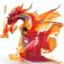
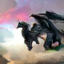
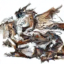
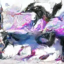
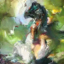
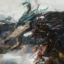

In [ ]:
generate_html_examples(cp="checkpoints/UNet128_2025-09-14_02-09-02_dragon.pth",batch_size=6)